## Setup for google colaboratory users
- If you use google colaboratory for your programming environment, please run the below. 
- You have to give a permission to refer the data in your google drive to import real data you have.

In [ ]:
# Mount Google Drive to read files in Colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

- Change "TS" to your own folder name. (the folder where you save the data)

In [ ]:
%cd "/content/drive/MyDrive/TS"

In [ ]:
ls

Firstly, import the libraries.

In [1]:
#Install the necessary libraries
!pip install -U statsmodels
#The code below is for displaying Japanese, install if you need.
#!pip install japanize_matplotlib


[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip


In [4]:
# Code2.1
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.tsa import filters as filt
from statsmodels.tsa.stattools import adfuller

In [2]:
#####
from matplotlib import pyplot as plt
from matplotlib.pylab import rcParams
rcParams["figure.figsize"] = 15, 6
#import japanize_matplotlib

Next, load the data. The data to be loaded is nominal GDP, real GDP and GDP deflator published by the Cabinet Office. Figure 2.1 is be created with these data.

In [25]:
#Code 2.2
# Load the data
gdp = pd.read_excel("data_2_eng.xlsx", sheet_name="annual GDP(cabinet)", header=[0])
ngdp, rgdp, gdpdef = gdp.iloc[:, 1], gdp.iloc[:, 2], gdp.iloc[:, 3]
gdpdef_cal = ngdp / rgdp * 100
# Output the data
print(gdp)

    Date  nominal GDP  real GDP  deflator
0   1994     510916.1  446522.3     114.4
1   1995     521613.5  458270.3     113.8
2   1996     535562.1  472631.9     113.3
3   1997     543545.4  477269.5     113.9
4   1998     536497.4  471206.6     113.9
5   1999     528069.9  469633.1     112.4
6   2000     535417.7  482616.8     110.9
7   2001     531653.9  484480.2     109.7
8   2002     524478.7  484683.5     108.2
9   2003     523968.6  492124.0     106.5
10  2004     529400.9  502882.4     105.3
11  2005     532515.6  511953.9     104.0
12  2006     535170.2  518979.7     103.1
13  2007     539281.7  526681.2     102.4
14  2008     527823.8  520233.1     101.5
15  2009     494938.4  490615.0     100.9
16  2010     505530.6  510720.0      99.0
17  2011     497448.9  510841.6      97.4
18  2012     500474.7  517864.4      96.6
19  2013     508700.6  528248.1      96.3
20  2014     518811.0  529812.8      97.9
21  2015     538032.3  538081.2     100.0
22  2016     544364.6  542137.4   

Text(0, 0.5, '2015=100')

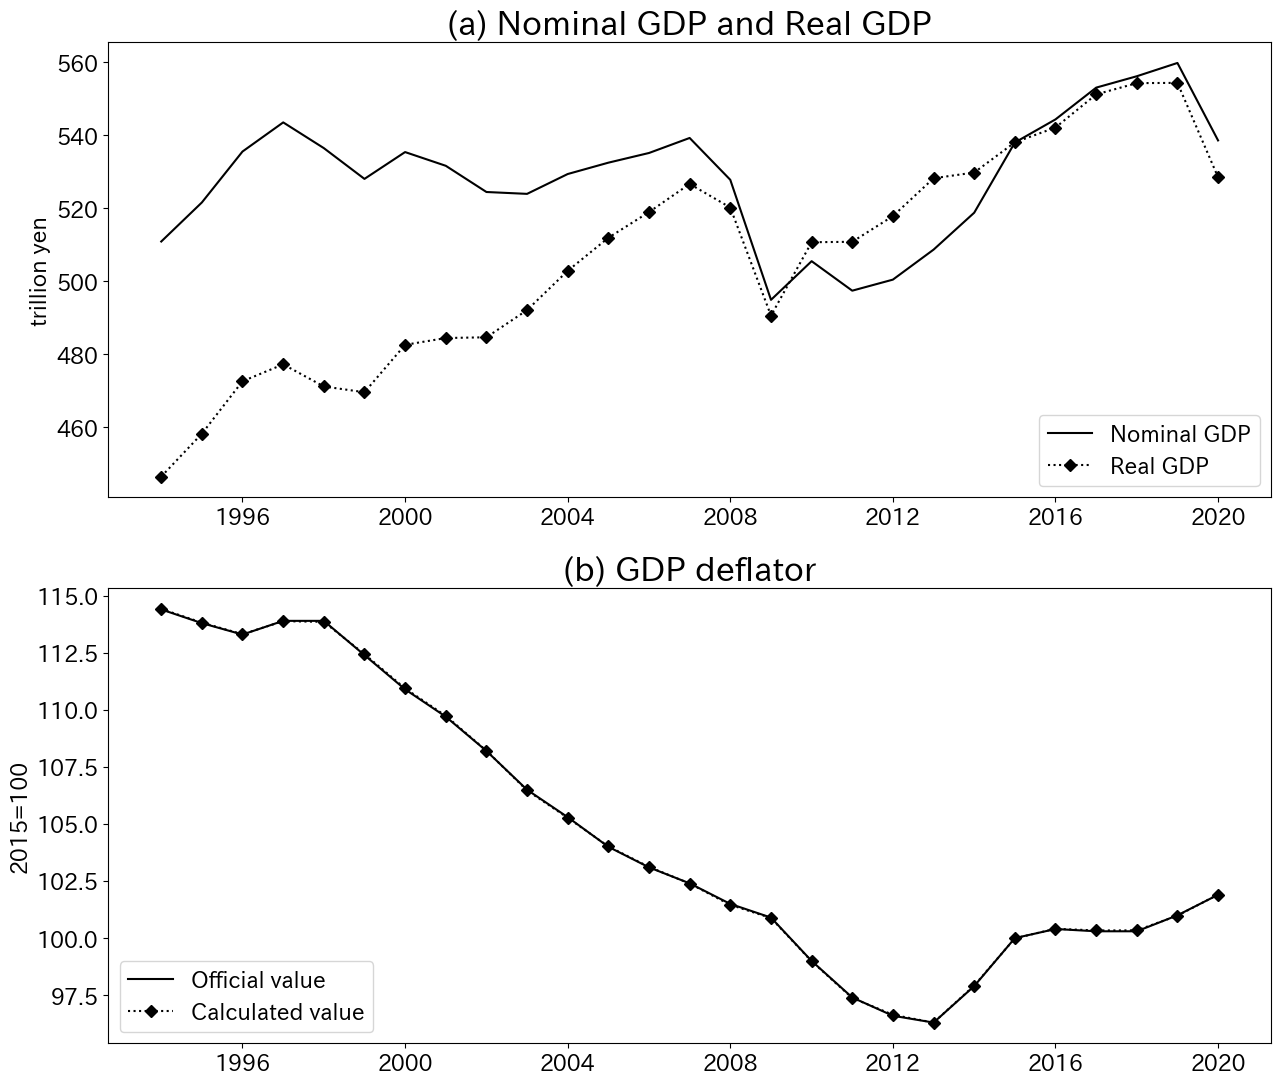

In [7]:
#####
# Draw the graph
fig = plt.figure(figsize=(15, 13))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
dti = pd.date_range("1994", periods=len(gdp), freq="YS")

ax1.set_title("(a) Nominal GDP and Real GDP", fontsize=24)
ax1.plot(dti, ngdp / 1000, label="Nominal GDP", color="black")
ax1.plot(dti, rgdp / 1000, label="Real GDP", color="black", linestyle = "dotted", marker="D")
ax1.legend(loc="lower right", fontsize=16)
ax1.tick_params(labelsize=16)
ax1.set_ylabel("trillion yen", fontsize=16)
ax2.set_title("(b) GDP deflator", fontsize=24)
ax2.plot(dti, gdpdef, label="Official value", color="black")
ax2.plot(dti, gdpdef_cal, label="Calculated value", color="black", linestyle = "dotted", marker="D")
ax2.legend(loc="lower left", fontsize=16)
ax2.tick_params(labelsize=16)
ax2.set_ylabel("2015=100", fontsize=16)

About the growth rate of real GDP, we compare the rate of change with the rate of change of the logarithmic approximation, then compute the Figure 2.2. 

In [8]:
# Code 2.3
# Rate of change and rate of change of the logarithmic approximation.
rch = (rgdp[1:].to_numpy() / rgdp[:-1].to_numpy() - 1) * 100
lch = (np.log(rgdp[1:].to_numpy()) - np.log(rgdp[:-1].to_numpy())) * 100

Text(0, 0.5, '%')

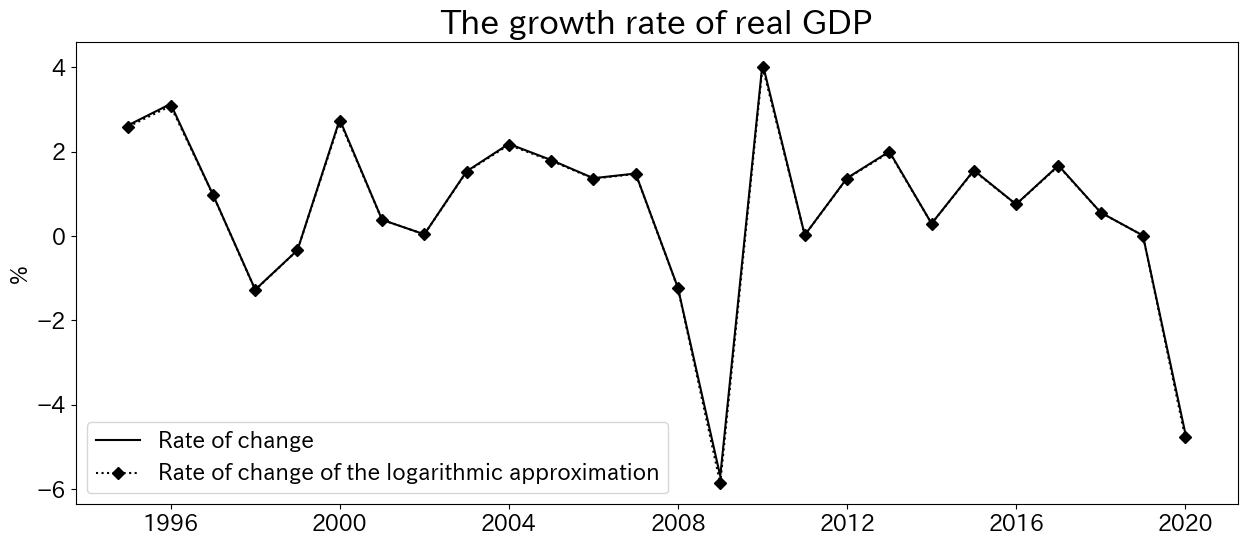

In [9]:
#####
# Draw the graph
plt.title("The growth rate of real GDP", fontsize=24)
plt.plot(dti[1:], rch, label="Rate of change", color="black")
plt.plot(dti[1:], lch, label="Rate of change of the logarithmic approximation", color="black", linestyle="dotted", marker="D")
plt.legend(loc="lower left", fontsize=16)
plt.tick_params(labelsize=16)
plt.ylabel("%", fontsize=16)

Load the original series of quarterly data for real GDP. The year-on-year, backward moving average (BMA) and centered moving average (CMA) that showed in Figure 2.3 are computed with following codes.

In [11]:
# Code 2.4
# Seasonal adjustment and moving average
# Load the data
qgdp = pd.read_excel("data_2_eng.xlsx", sheet_name="quarterly GDP original(cabinet)", header=[0])
qdti = pd.date_range("1994-01-01", periods=len(qgdp), freq="QS")
rqgdp = qgdp.iloc[:, 2]

# Year-on-year
qrch = (rqgdp[4:].to_numpy() / rqgdp[:-4].to_numpy() - 1) * 100
qlch = (np.log(rqgdp[4:].to_numpy()) - np.log(rqgdp[:-4].to_numpy())) * 100

# Backward moving average・Centered moving average
qqlch = (np.log(rqgdp[1:].to_numpy()) - np.log(rqgdp[:-1].to_numpy())) * 400
BMA_qqlch = (pd.DataFrame(qqlch)).rolling(window=4, center=False).mean()
CMA_qqlch = (
    (pd.DataFrame(qqlch)).rolling(window=4, center=False).mean().shift(-1)
    + (pd.DataFrame(qqlch)).rolling(window=4, center=False).mean().shift(-2)
) / 2

Text(0, 0.5, '%')

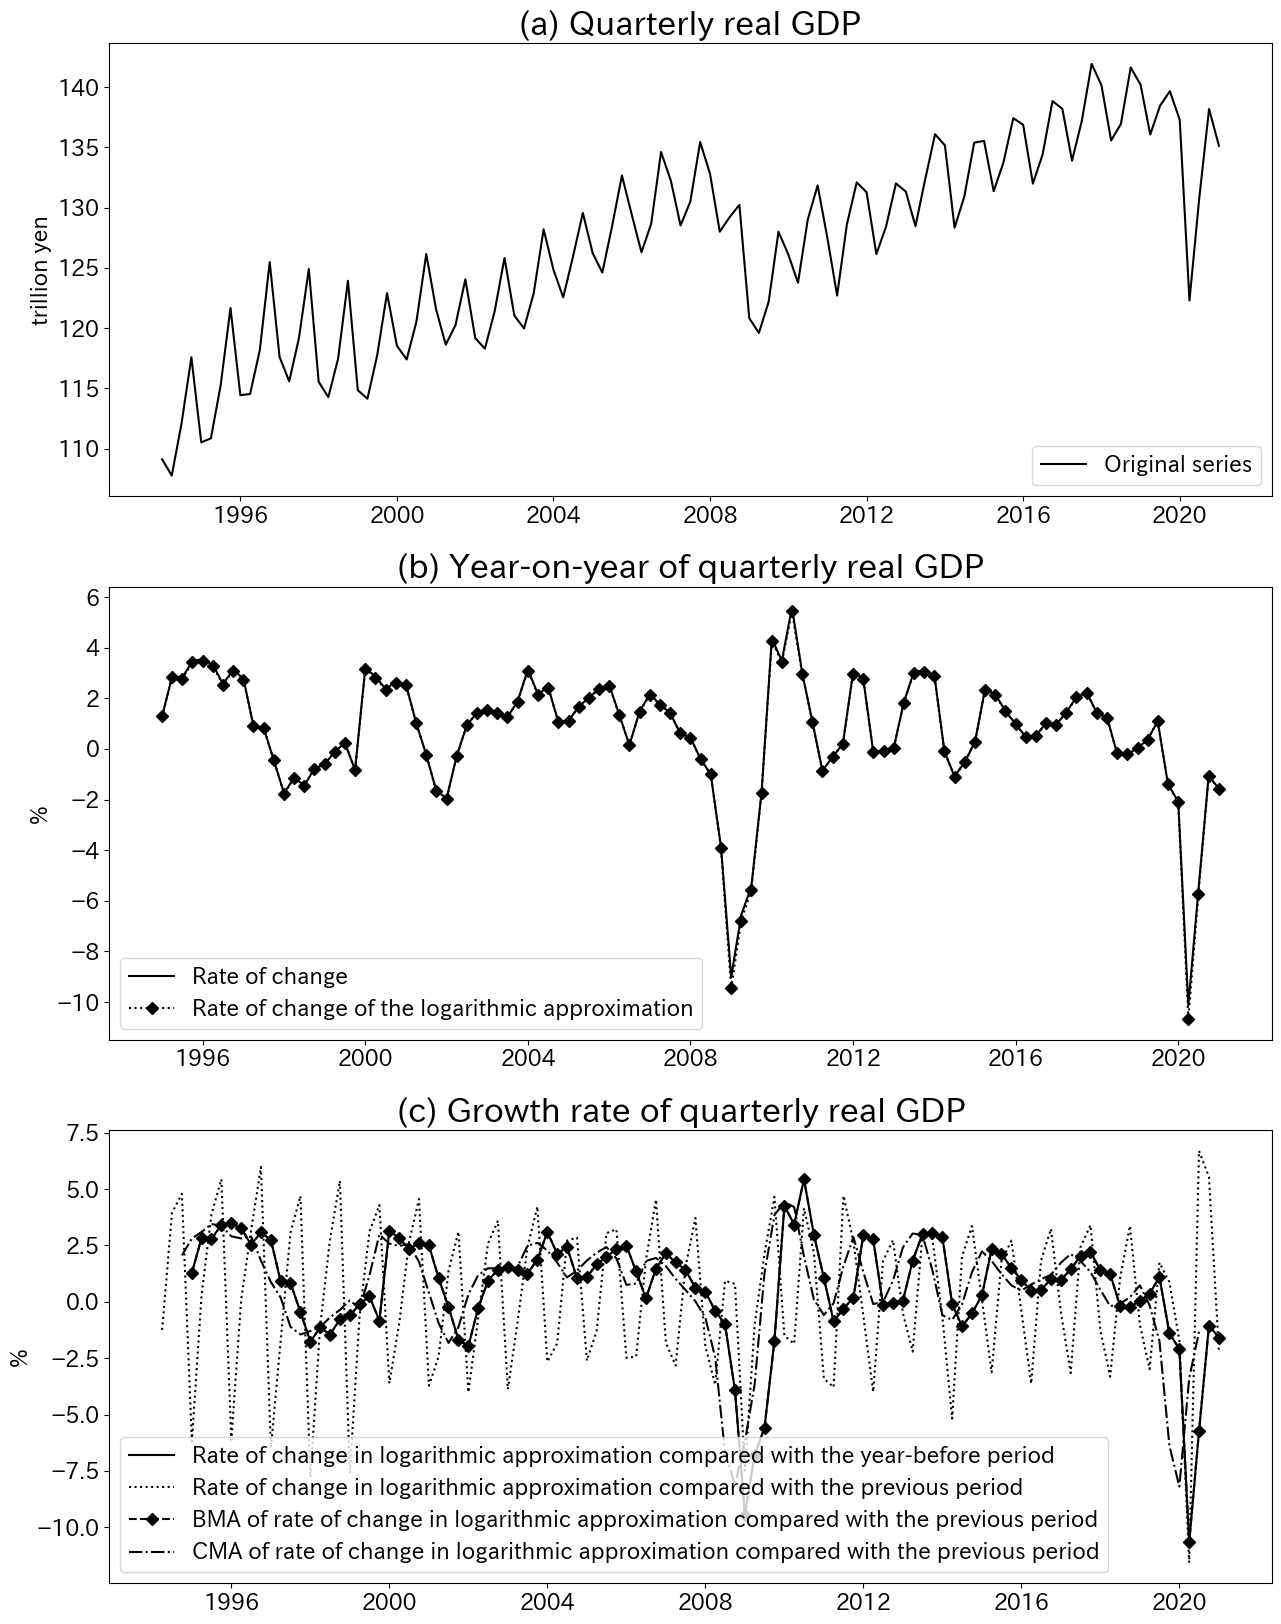

In [15]:
#####
# Draw the graph
fig = plt.figure(figsize=(15, 20))
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)
ax1.set_title("(a) Quarterly real GDP", fontsize=24)
ax1.plot(qdti, rqgdp / 1000, label="Original series", color="black")
ax1.legend(loc="lower right", fontsize=16)
ax1.tick_params(labelsize=16)
ax1.set_ylabel("trillion yen", fontsize=16)
# Year-on-year
ax2.set_title("(b) Year-on-year of quarterly real GDP", fontsize=24)
ax2.plot(qdti[4:], qrch, label="Rate of change", color="black")
ax2.plot(qdti[4:], qlch, label="Rate of change of the logarithmic approximation", color="black", linestyle="dotted", marker="D")
ax2.legend(loc="lower left", fontsize=16)
ax2.tick_params(labelsize=16)
ax2.set_ylabel("%", fontsize=16)
# 4 quarters backward moving average・4 quarters centered moving average
ax3.set_title("(c) Growth rate of quarterly real GDP  ", fontsize=24)
ax3.plot(qdti[4:], qlch, label="Rate of change in logarithmic approximation compared with the year-before period", color="black")
ax3.plot(
    qdti[1:],
    (np.log(rqgdp[1:].to_numpy()) - np.log(rqgdp[:-1].to_numpy())) * 100,
    label="Rate of change in logarithmic approximation compared with the previous period",
    color="black",
    linestyle="dotted",
)
ax3.plot(qdti[1:], BMA_qqlch.to_numpy(), label="BMA of rate of change in logarithmic approximation compared with the previous period", color="black", linestyle="dashed", marker="D")
ax3.plot(qdti[1:], CMA_qqlch.to_numpy(), label="CMA of rate of change in logarithmic approximation compared with the previous period", color="black", linestyle="dashdot")
ax3.legend(loc="lower left", fontsize=16)
ax3.tick_params(labelsize=16)
ax3.set_ylabel("%", fontsize=16)

The HP-filtered detrend shown in Figure 2.4 can be computed with the following code。Note that as the variable under consideration this time is the seasonally adjusted quarterly series of real GDP、based on Table 2.1、we let λ=1,600 in the code.

In [16]:
# Code 2.5
# Load the data
qsagdp = pd.read_excel("data_2_eng.xlsx", sheet_name="quarterly GDP SA(cabinet)", header=[0])
rqsagdp = qsagdp.iloc[:, 2]
gap = qsagdp.iloc[:, 4]

# Calculate the HP filter (tuning parameter=1600)
hp = filt.hp_filter.hpfilter(np.log(rqsagdp), lamb=1600)
hp_cycle, hp_trend = pd.DataFrame(hp[0]), pd.DataFrame(hp[1])

Text(0, 0.5, '%')

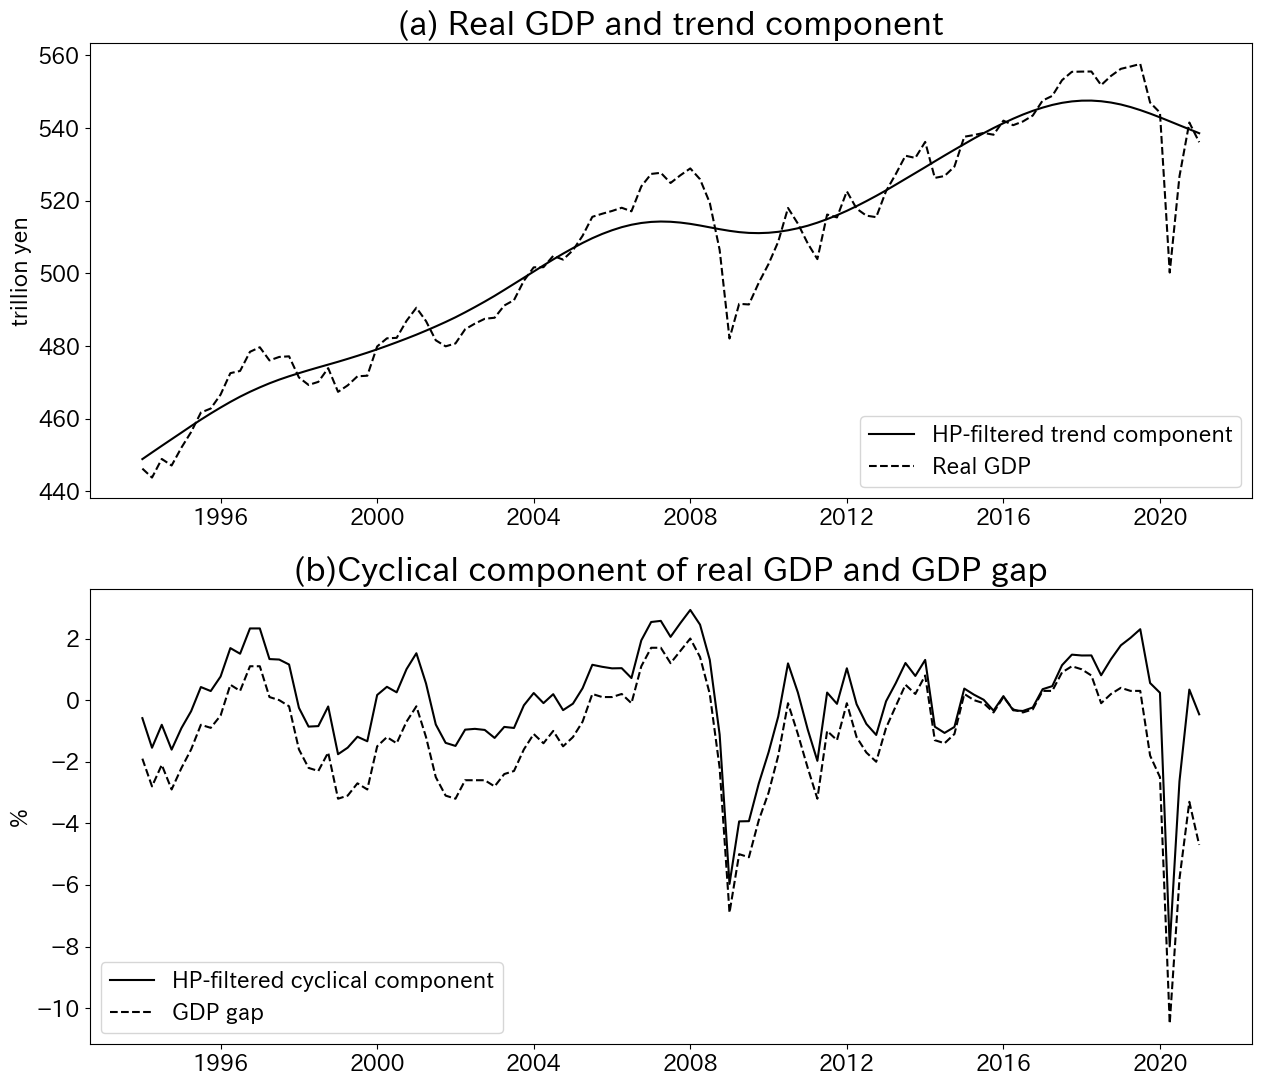

In [17]:
#####
# Draw the graph
fig = plt.figure(figsize=(15, 13))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.set_title("(a) Real GDP and trend component", fontsize=24)
ax1.plot(qdti, (np.exp(hp_trend) / 1000).to_numpy(), label="HP-filtered trend component", color="black")
ax1.plot(qdti, rqsagdp / 1000, label="Real GDP", color="black", linestyle="dashed")
ax1.legend(loc="lower right", fontsize=16)
ax1.tick_params(labelsize=16)
ax1.set_ylabel("trillion yen", fontsize=16)
ax2.set_title("(b)Cyclical component of real GDP and GDP gap", fontsize=24)
ax2.plot(qdti, (hp_cycle.to_numpy()) * 100, label="HP-filtered cyclical component", color="black")
ax2.plot(qdti, gap, label="GDP gap", color="black", linestyle="dashed")
ax2.legend(loc="lower left", fontsize=16)
ax2.tick_params(labelsize=16)
ax2.set_ylabel("%", fontsize=16)

The unit root test (ADF test) in Table 2.3 can be computed by following code. DF regression equation is formulated with "regression", "n": there is neither a constant term nor a linear trend, "c": there is only a constant, "ct": there is both a constant and a linear trend. The lag order selection criteria can be set in "autolag". Note that the critical values displayed here do not necessarily correspond to those in Table 2.2 due to finite sample modifications.

In [18]:
# Code 2.6
# Unit root test
# ADF test for GDP gap
adf = adfuller(gap, regression="n", autolag="AIC")
print("[ADF test for GDP gap]")
print(f"ADF test statistic: {adf[0]}")
print(f"p value: {adf[1]}")
print(f"critical value: {adf[4]}")

# ADF test for real GDP 
adf = adfuller(np.log(rqsagdp), regression="ct", autolag="AIC")
print("[ADF test for quarterly real GDP]")
print(f"ADF test statistic: {adf[0]}")
print(f"p value: {adf[1]}")
print(f"critical value: {adf[4]}")

# ADF test for the first-order difference of real GDP
adf = adfuller(
    np.log(rqsagdp[1:].to_numpy()) - np.log(rqsagdp[:-1].to_numpy()),
    regression="c",
    autolag="AIC",
)
print("[Unit root test for the first-order difference of real GDP]")
print(f"ADF test statistic: {adf[0]}")
print(f"p value: {adf[1]}")
print(f"critical value: {adf[4]}")

[ADF test for GDP gap]
ADF test statistic: -2.867571971238672
p value: 0.004050069464733379
critical value: {'1%': -2.5867528086419753, '5%': -1.9437507457260073, '10%': -1.6145732877356094}
[ADF test for quarterly real GDP]
ADF test statistic: -3.1660517629849387
p value: 0.09138099162938612
critical value: {'1%': -4.045138739362648, '5%': -3.45195256255398, '10%': -3.1513450121932634}
[Unit root test for the first-order difference of real GDP]
ADF test statistic: -10.94442883761833
p value: 9.122844796764178e-20
critical value: {'1%': -3.492995948509562, '5%': -2.888954648057252, '10%': -2.58139291903223}


The detrending by BN decomposition in Table 2.5 can be computed with the following code. The lag order of AR model of the difference series can be adjusted by changing the value of "L" in the code.

In [19]:
# Code 2.7
# BN decomposition
dgdp = pd.DataFrame(np.log(rqsagdp)[1:].to_numpy() - np.log(rqsagdp)[:-1].to_numpy())
ssize = len(dgdp)

L = 4  # Lag order of AR model（4 quarters）
y = pd.DataFrame(dgdp[(L - 1) + 1 : ssize])
x = pd.DataFrame()
for ll in range(1, L + 1):
    temp = pd.DataFrame(dgdp[L - ll : ssize + L - ll - (L - 1) - 1].to_numpy())
    x = pd.concat([x, temp], axis=1)

# Estimation of AR model
model = LinearRegression()
model.fit(x, y)
bmat = np.zeros((L, L))
bmat[0, :] = model.coef_
for i in range(1, L):
    bmat[i, i - 1] = 1
cvec, dvec = np.zeros((1, L)), np.zeros((1, L))
cvec[:, 0] = 1
dvec[:, 0] = (model.intercept_) / (1 - np.sum(model.coef_))
i_mat = np.eye(L)

delta_y = np.zeros([ssize + 1, L])
bn_trend, bn_cycle = np.zeros(ssize + 1), np.zeros(ssize + 1)
for i in range(L, ssize + 1):
    temp1 = dgdp[i - L : i].to_numpy()
    temp2 = temp1[::-1, :]
    delta_y[i] = temp2.reshape(L)
    #trends component of BN decomposition
    bn_trend[i] = cvec @ (
        bmat @ (np.linalg.inv(i_mat - bmat)) @ (delta_y[i] - dvec).T
        + np.log(rqsagdp)[i]
    )
    # cyclical component of BN decomposition
    bn_cycle[i] = -cvec @ bmat @ np.linalg.inv(i_mat - bmat) @ (delta_y[i] - dvec).T

Text(0, 0.5, '%')

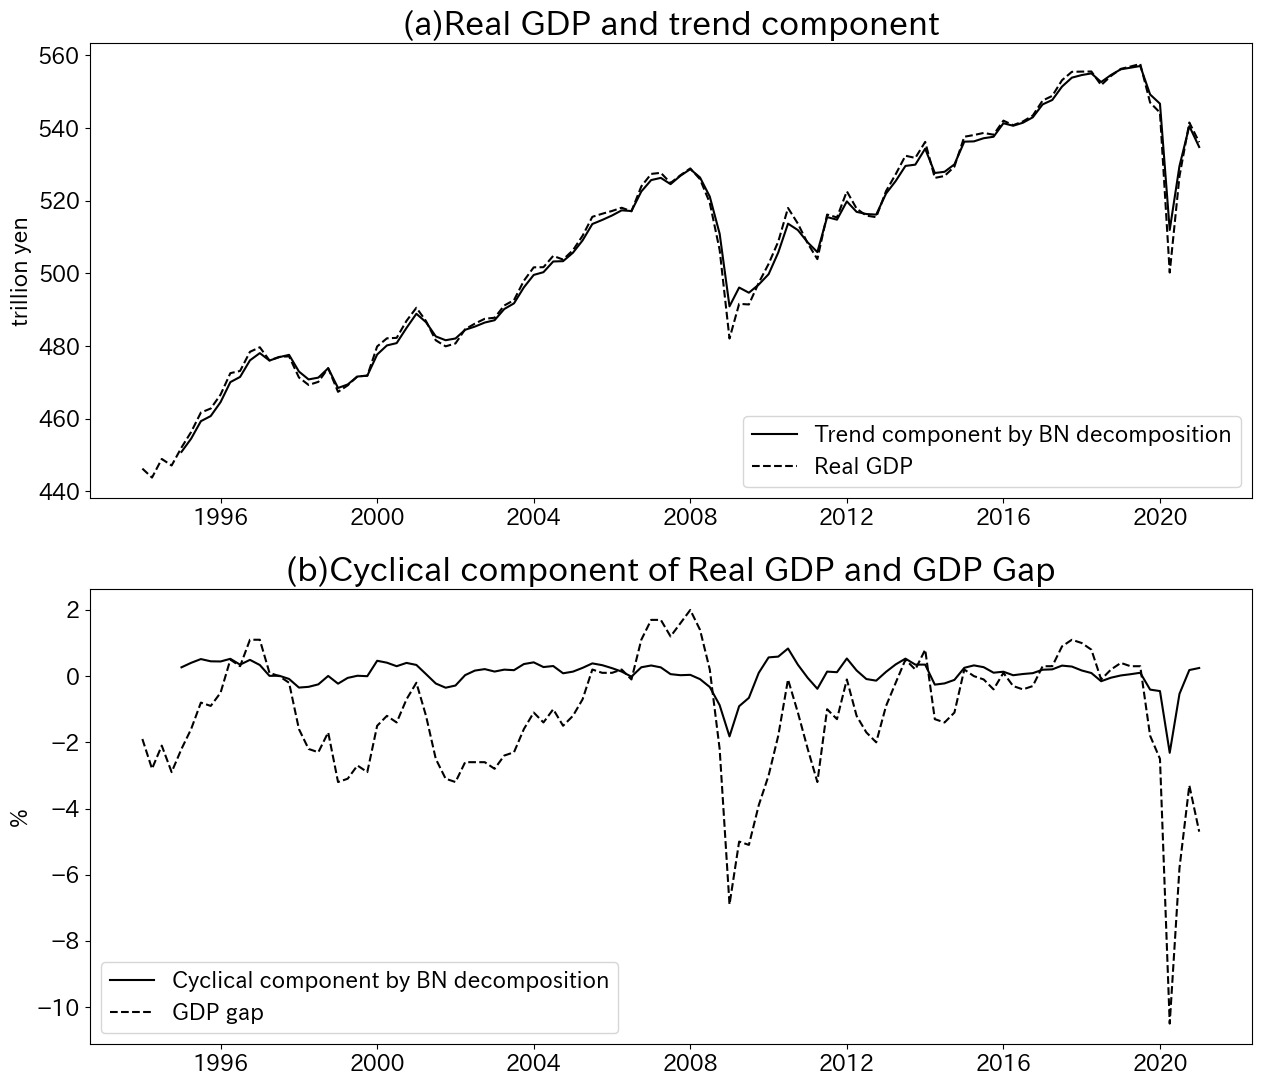

In [20]:
#####
# Draw the graph
fig = plt.figure(figsize=(15, 13))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.set_title("(a)Real GDP and trend component", fontsize=24)
ax1.plot(qdti[L:], np.exp(bn_trend)[L:] / 1000, label="Trend component by BN decomposition", color="black")
ax1.plot(qdti, rqsagdp / 1000, label="Real GDP", color="black", linestyle="dashed")
ax1.legend(loc="lower right", fontsize=16)
ax1.tick_params(labelsize=16)
ax1.set_ylabel("trillion yen", fontsize=16)
ax2.set_title("(b)Cyclical component of Real GDP and GDP Gap", fontsize=24)
ax2.plot(qdti[L:], (bn_cycle[L:]) * 100, label="Cyclical component by BN decomposition", color="black")
ax2.plot(qdti, gap, label="GDP gap", color="black", linestyle="dashed")
ax2.legend(loc="lower left", fontsize=16)
ax2.tick_params(labelsize=16)
ax2.set_ylabel("%", fontsize=16)

The detrending by UC model in Table 2.6 can be computed with the following code. In this case, the trend component is a random walk with drift, so we use "rwdrift", Other options include "ntrend" (no trend term) and "rwalk" (random walk) as well. The lag order of the cyclical component can be adjusted by changing the value of "autoregressive".

In [21]:
# Code 2.8
# UC model
mod_ucarima = sm.tsa.UnobservedComponents(np.log(rqsagdp), "rwdrift", autoregressive=2)
res_ucarima = mod_ucarima.fit(method="powell", disp=False)

Text(0, 0.5, '%')

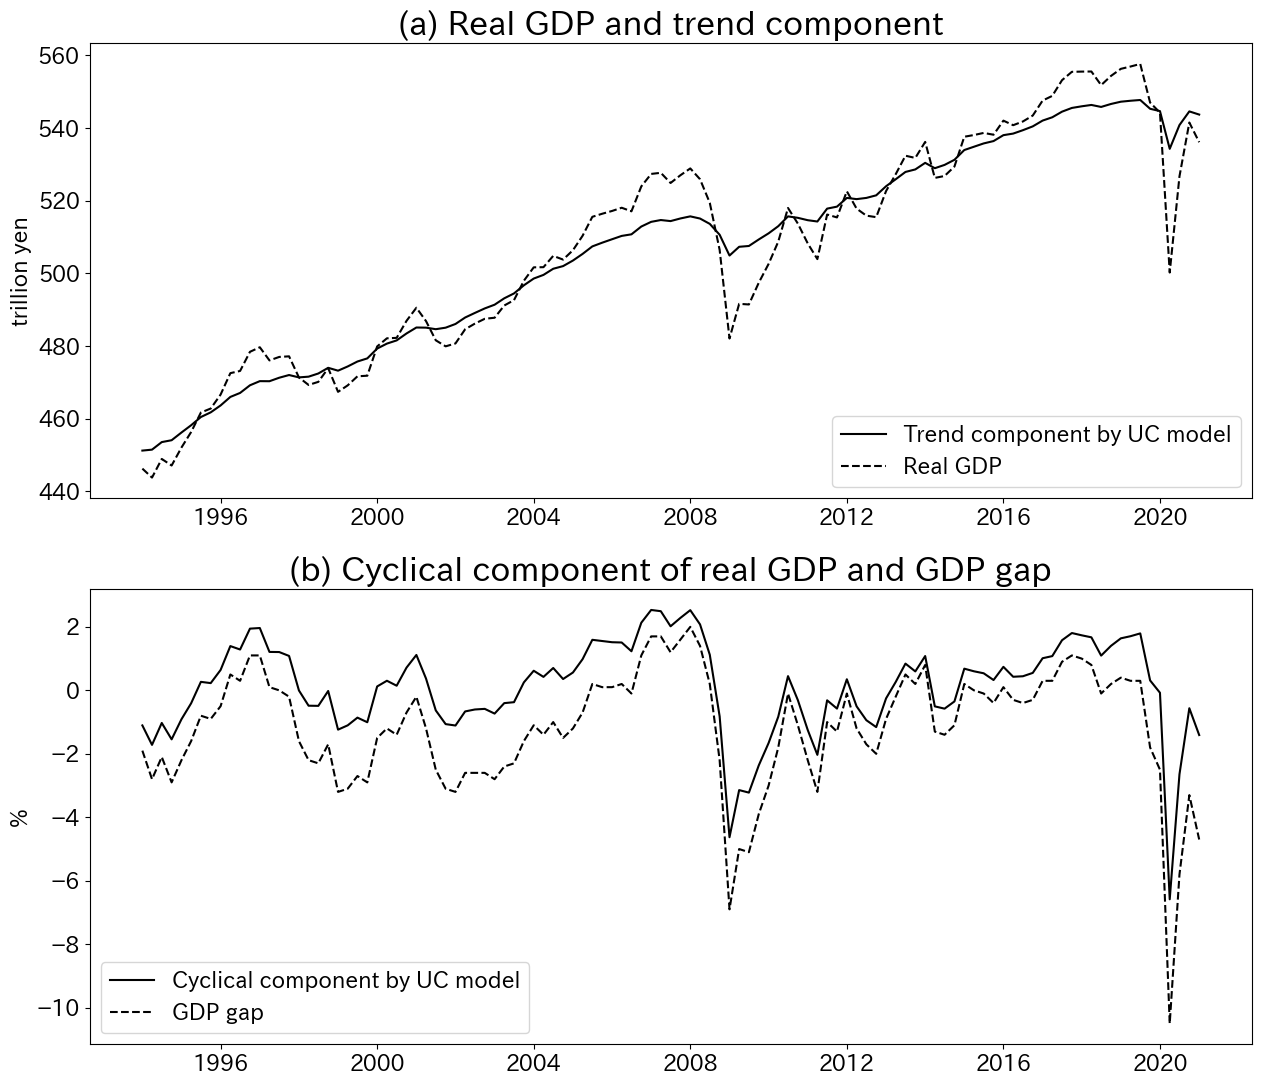

In [22]:
#####
# Draw the graph
fig = plt.figure(figsize=(15, 13))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.set_title("(a) Real GDP and trend component", fontsize=24)
ax1.plot(qdti, np.exp(res_ucarima.level.smoothed) / 1000, label="Trend component by UC model", color="black")
ax1.plot(qdti, rqsagdp / 1000, label="Real GDP", color="black", linestyle="dashed")
ax1.legend(loc="lower right", fontsize=16)
ax1.tick_params(labelsize=16)
ax1.set_ylabel("trillion yen", fontsize=16)
ax2.set_title("(b) Cyclical component of real GDP and GDP gap", fontsize=24)
ax2.plot(qdti, (np.log(rqsagdp) - res_ucarima.level.smoothed) * 100, label="Cyclical component by UC model", color="black")
ax2.plot(qdti, gap, label="GDP gap", color="black", linestyle="dashed")
ax2.legend(loc="lower left", fontsize=16)
ax2.tick_params(labelsize=16)
ax2.set_ylabel("%", fontsize=16)